In [1]:
import os
import glob
import time
import math

import numpy as np
import pandas as pd
import xarray as xr
import rioxarray
import geopandas as gpd
from shapely.geometry import mapping
from rasterio.enums import Resampling

In [2]:
# Set path to grace dir
grace_dir = '/home/dev/grace_dir/'

In [3]:
# Reading the NW Bangladesh shapefile
gdf = gpd.read_file(os.path.join(grace_dir, 'NorthWestBD.shp'))
gdf

,OBJECTID,Shape_Leng,Shape_Area,geometry
0,1,18.876597,3.089947,"MULTIPOLYGON (((88.93296 26.33316, 88.93322 26..."


In [4]:
# Load Concatenated GLDAS Model Files
gldas_vic_ds = xr.open_dataset(os.path.join(grace_dir, 'vic.nc'))
gldas_clsm_ds = xr.open_dataset(os.path.join(grace_dir, 'clsm.nc'))
gldas_noah_ds = xr.open_dataset(os.path.join(grace_dir,'noah.nc'))

In [5]:
# Clip GLDAS Model file to given GeoDataFrame
def clip_gldas_ds(ds, gdf): 
    # Looping through the variables and setting a spatial dimension so that they can be clipped
    for var in ds.variables:
        if var not in ['lat', 'lon', 'time']:
            ds[var] = ds[var].rio.write_crs("epsg:4326") 
    ds.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
    clipped_ds = ds.rio.clip(gdf.geometry.apply(mapping), gdf.crs, drop=True)
    return clipped_ds

In [6]:
# Calculate Surface Area of Grid Cell
def calculate_surface_area(ds):
    # Find the lon size
    lon_interval_size = ds.variables['lon'][1] - ds.variables['lon'][0]
    # Find the lat size
    lat_interval_size = ds.variables['lat'][1] - ds.variables['lat'][0]
    surface_area_array = np.array([6371000*math.radians(lat_interval_size)*6371000*math.radians(lon_interval_size)*math.cos(math.radians(lat)) for lat in ds.lat.values])
    return surface_area_array

In [7]:
def resample_grace(ds, scale_factor, resampling):
    new_width = int(ds.rio.width * scale_factor)
    new_height = int(ds.rio.height * scale_factor)
    ds.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
    ds.rio.write_crs("epsg:4326", inplace=True)
    ds_sampled = ds.rio.reproject(
        ds.rio.crs,
        shape=(new_height, new_width),
        resampling=resampling,
    )
    ds_sampled = ds_sampled.reindex(y=ds_sampled.y[::-1]).rename({'y': 'lat', 'x': 'lon'})
    return ds_sampled

In [8]:
# Unit Factors Dict
unit_factors = {"mm": 1000, "kg/m2": 1000, "kg/m^2": 1000, "cm": 100, "dm": 10, "m": 1, "km": .001, "kg m-2": 1000}

In [9]:
# For a given gldas dataset and surface area data array calculate anomalies for each variable
def calculate_gldas_anomalies(ds, surface_area_da):
    for var in ds.variables:
        if var not in ['lat', 'lon', 'time', 'spatial_ref']:
            # Calculate variable mean from 2004 to 2009
            var_mean = ds.sel(time=slice('2004-01-01', '2009-12-31')).mean('time')[var]
            var_factor = unit_factors[ds[var].units]
            ds[var] = (ds[var] - var_mean)/var_factor * surface_area_da
            ds[var] = ds[var]*100/surface_area_da
    return ds

In [10]:
# GLDAS Grid Cell Area
areas = calculate_surface_area(gldas_clsm_ds)

surface_area_da = (xr.DataArray(areas, dims=['lat'],
                                coords={'lat': gldas_clsm_ds.lat})
                   .expand_dims(lon=len(gldas_clsm_ds.coords['lon']))
                   .assign_coords(lon=gldas_clsm_ds.lon)
                   .transpose('lat', 'lon')
#                    .drop('spatial_ref')
                  )
surface_area_da

<xarray.DataArray (lat: 150, lon: 360)>
array([[6.27536253e+09, 6.27536253e+09, 6.27536253e+09, ...,
        6.27536253e+09, 6.27536253e+09, 6.27536253e+09],
       [6.46033512e+09, 6.46033512e+09, 6.46033512e+09, ...,
        6.46033512e+09, 6.46033512e+09, 6.46033512e+09],
       [6.64333984e+09, 6.64333984e+09, 6.64333984e+09, ...,
        6.64333984e+09, 6.64333984e+09, 6.64333984e+09],
       ...,
       [5.39323702e+08, 5.39323702e+08, 5.39323702e+08, ...,
        5.39323702e+08, 5.39323702e+08, 5.39323702e+08],
       [3.23659949e+08, 3.23659949e+08, 3.23659949e+08, ...,
        3.23659949e+08, 3.23659949e+08, 3.23659949e+08],
       [1.07897605e+08, 1.07897605e+08, 1.07897605e+08, ...,
        1.07897605e+08, 1.07897605e+08, 1.07897605e+08]])
Coordinates:
  * lat      (lat) float32 -59.5 -58.5 -57.5 -56.5 -55.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

In [11]:
# Calculate Anomalies for each model
gldas_clsm_anomalies = calculate_gldas_anomalies(gldas_clsm_ds, surface_area_da)
gldas_noah_anomalies = calculate_gldas_anomalies(gldas_noah_ds, surface_area_da)
gldas_vic_anomalies = calculate_gldas_anomalies(gldas_vic_ds, surface_area_da)

In [12]:
# Declare TWS variables that need to be summed

clsm_tws_variables = ['SWE_inst', 'CanopInt_inst', 'SoilMoist_P_inst']

noah_tws_variables = ['SWE_inst', 'CanopInt_inst', 'SoilMoi0_10cm_inst',
                      'SoilMoi10_40cm_inst', 'SoilMoi40_100cm_inst',
                      'SoilMoi100_200cm_inst'
                     ]

vic_tws_variables = ['SWE_inst', 'CanopInt_inst', 
                     'SoilMoi0_30cm_inst', 'SoilMoi_depth2_inst',
                     'SoilMoi_depth3_inst'
                    ]

In [13]:
# Declare Surface Water Variables
clsm_sw_variables = ['SWE_inst', 'CanopInt_inst']

noah_sw_variables = ['SWE_inst', 'CanopInt_inst']

vic_sw_variables = ['SWE_inst', 'CanopInt_inst']

In [14]:
# Declare Soil Moisture variables
clsm_sm_variables = ['SoilMoist_P_inst']

noah_sm_variables = ['SoilMoi0_10cm_inst', 'SoilMoi10_40cm_inst', 'SoilMoi40_100cm_inst',
                      'SoilMoi100_200cm_inst']

vic_sm_variables = ['SoilMoi0_30cm_inst', 'SoilMoi_depth2_inst', 'SoilMoi_depth3_inst']

In [15]:
# Declare Canopy Variables
clsm_canopy_variables = ['CanopInt_inst']

noah_canopy_variables = ['CanopInt_inst']

vic_canopy_variables = ['CanopInt_inst']

In [16]:
# Declare Snow Water Equivalent Variables
clsm_swe_variables = ['SWE_inst']

noah_swe_variables = ['SWE_inst']

vic_swe_variables = ['SWE_inst']

In [17]:
def aggregate_gldas_anomalies(clsm_variables, noah_variables, vic_variables, variable_name):
    clsm_ds = gldas_clsm_anomalies[clsm_variables].to_array().sum('variable').to_dataset(name=variable_name)
    noah_ds = gldas_noah_anomalies[noah_variables].to_array().sum('variable').to_dataset(name=variable_name)
    vic_ds = gldas_vic_anomalies[vic_variables].to_array().sum('variable').to_dataset(name=variable_name)
    # create a new dataset with all the model tws mean values
    # returns a single value at each time step
    model_ds = xr.Dataset({
        'clsm': clsm_ds[variable_name],
        'noah': noah_ds[variable_name],
        'vic': vic_ds[variable_name]
    })
    
    # create a final netcdf array with the mean and std values
    final_ds = xr.Dataset({'lwe_thickness': model_ds.to_array().mean('variable'),
                           'uncertainty': model_ds.to_array().std('variable')})
    return final_ds

In [18]:
final_sw_ds = aggregate_gldas_anomalies(clsm_sw_variables, noah_sw_variables, vic_sw_variables, 'lwe_thickness')

In [19]:
final_sw_ds.to_netcdf('global_sw.nc')

In [20]:
final_sm_ds = aggregate_gldas_anomalies(clsm_sm_variables, noah_sm_variables, vic_sm_variables, 'lwe_thickness')

In [21]:
final_sm_ds.to_netcdf('global_sm.nc')

In [22]:
final_swe_ds = aggregate_gldas_anomalies(clsm_swe_variables, noah_swe_variables, vic_swe_variables, 'lwe_thickness')

In [23]:
final_swe_ds.to_netcdf('global_swe.nc')

In [24]:
final_canopy_ds = aggregate_gldas_anomalies(clsm_canopy_variables, noah_canopy_variables, vic_canopy_variables, 'lwe_thickness')

In [25]:
final_canopy_ds.to_netcdf('global_canopy.nc')

In [26]:
final_tws_ds = aggregate_gldas_anomalies(clsm_tws_variables, noah_tws_variables, vic_tws_variables, 'lwe_thickness')

In [27]:
final_tws_ds.to_netcdf('global_tws.nc')

In [28]:
final_tws_ds = xr.open_dataset('global_tws.nc').load()

In [29]:
clipped_tws_ds = clip_gldas_ds(final_tws_ds, gdf)
clipped_tws_ds

<xarray.Dataset>
Dimensions:        (lat: 3, lon: 2, time: 253)
Coordinates:
  * lat            (lat) float64 24.5 25.5 26.5
  * lon            (lon) float64 88.5 89.5
  * time           (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2021-01-01
    spatial_ref    int64 0
Data variables:
    lwe_thickness  (time, lat, lon) float64 -10.13 -3.945 nan ... -6.809 nan
    uncertainty    (time, lat, lon) float64 4.824 3.95 nan ... 5.189 7.926 nan

In [30]:
tws_df = clipped_tws_ds.lwe_thickness.mean(['lat', 'lon']).to_dataframe().reset_index()
tws_df

,time,spatial_ref,lwe_thickness
0,2000-01-01,0,-5.642283
1,2000-02-01,0,-11.419013
2,2000-03-01,0,-18.982549
3,2000-04-01,0,-22.664035
4,2000-05-01,0,-12.706173
...,...,...,...
248,2020-09-01,0,22.526328
249,2020-10-01,0,19.831935
250,2020-11-01,0,8.652233
251,2020-12-01,0,0.023357


In [31]:
# GRACE Processinglwe_thickness

In [32]:
# Open GRACE netcdf file
grace_ds = xr.open_dataset(os.path.join(grace_dir, 'latest_jpl_grace.nc'))[['lwe_thickness', 'uncertainty']]

In [33]:
# Clipping the grace ds to utah shapefile
ds = grace_ds.copy()
ds = ds.assign({"lon": (((ds.lon + 180) % 360) - 180)}).sortby('lon')
ds['lwe_thickness'] = ds['lwe_thickness'].rio.write_crs("epsg:4326")
ds['uncertainty'] = ds['uncertainty'].rio.write_crs("epsg:4326")
ds.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)

<xarray.Dataset>
Dimensions:        (lat: 360, lon: 720, time: 195)
Coordinates:
  * lon            (lon) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * lat            (lat) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time           (time) datetime64[ns] 2002-04-17T12:00:00 ... 2021-03-16T1...
    WGS84          int64 0
Data variables:
    lwe_thickness  (time, lat, lon) float64 ...
    uncertainty    (time, lat, lon) float64 ...
Attributes: (12/53)
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         JPL GRACE and GRACE-FO MASCON RL06Mv2 CRI
    summary:                       Monthly gravity solutions from GRACE and G...
    keywords:                      Solid Earth, Geodetics/Gravity, Gravity, l...
    ...                            ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...
    journal_reference:             Watkins, M. M., D. N. Wiese, D.-N. Yuan, C...
    CRI_filter_journal_reference:  Wiese, D. N., F. W. Landerer, and M. M. Wa...
    date_created:                  2021-04-27T21:04:06Z

In [34]:
# Clipping Scale Factors NetCDF file
sf_ds = xr.open_dataset(os.path.join(grace_dir, 'scale_factors.nc'))
sf_ds = sf_ds.assign({"lon": (((sf_ds.lon + 180) % 360) - 180)}).sortby('lon')
sf_ds['scale_factor'] = sf_ds['scale_factor'].rio.write_crs("epsg:4326")
sf_ds.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)

<xarray.Dataset>
Dimensions:       (lat: 360, lon: 720)
Coordinates:
  * lon           (lon) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * lat           (lat) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
    spatial_ref   int64 0
Data variables:
    scale_factor  (lat, lon) float64 ...
Attributes: (12/20)
    Conventions:                CF-1.5
    Metadata_Conventions:       Unidata Dataset Discovery v1.0
    standard_name_vocabulary:   CF-1.5
    title:                      Scale Factor - CRI
    summary:                    Scale factors to be applied to mascon solutio...
    filename:                   NETCDF/RL06Mv2/CLM4.SCALE_FACTOR.JPL.MSCNv01C...
    ...                         ...
    geospatial_lat_resolution:  0.5 degree grid
    geospatial_lon_min:         0.25
    geospatial_lon_max:         359.75
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.5 degree grid
    DATE_CREATED:               25-Nov-2019 10:03:31

In [35]:
# Calculate GRACE grid cell area
grace_areas = calculate_surface_area(sf_ds)

In [36]:
grace_area_da = xr.DataArray(grace_areas, dims=['lat'], coords={'lat': sf_ds.lat}).expand_dims(lon=len(sf_ds.coords['lon'])).assign_coords(lon=sf_ds.lon)

In [37]:
# Calculate GRACE TWS Anomalies

# Calculate grid cell long term mean
grid_cell_mean = ds.sel(time=slice('2004-01-01', '2009-12-31')).mean('time').lwe_thickness
# grace_clipped.sel(time=slice('2004-01-01', '2009-12-31')).mean('time').lwe_thickness
# Calculate anamolies based on grid cell mean, scale factor and surface area
gw_wsa_da = (ds.lwe_thickness - grid_cell_mean) * sf_ds.scale_factor
final_gw_da = gw_wsa_da.copy()

In [38]:
del ds.uncertainty.attrs['grid_mapping']

In [39]:
final_grace_ds = xr.Dataset({'lwe_thickness': final_gw_da, 'uncertainty': ds.uncertainty})
final_grace_ds.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
final_grace_ds = final_grace_ds.drop_vars(['WGS84', 'spatial_ref'])
final_grace_ds

<xarray.Dataset>
Dimensions:        (lat: 360, lon: 720, time: 195)
Coordinates:
  * lon            (lon) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * lat            (lat) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time           (time) datetime64[ns] 2002-04-17T12:00:00 ... 2021-03-16T1...
Data variables:
    lwe_thickness  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    uncertainty    (time, lat, lon) float64 ...

In [40]:
final_grace_ds.to_netcdf('global_grace.nc')

In [41]:
final_grace_ds = xr.open_dataset('global_grace.nc')

In [42]:
final_grace_ds.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
final_grace_ds.rio.write_crs("epsg:4326", inplace=True)
final_grace_ds

<xarray.Dataset>
Dimensions:        (lat: 360, lon: 720, time: 195)
Coordinates:
  * lon            (lon) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * lat            (lat) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time           (time) datetime64[ns] 2002-04-17T12:00:00 ... 2021-03-16T1...
    spatial_ref    int64 0
Data variables:
    lwe_thickness  (time, lat, lon) float64 ...
    uncertainty    (time, lat, lon) float64 ...

In [43]:
clipped_grace = clip_gldas_ds(final_grace_ds, gdf)

In [44]:
grace_df = clipped_grace.lwe_thickness.mean(['lat', 'lon']).to_dataframe().reset_index().dropna()
grace_df

,time,WGS84,spatial_ref,lwe_thickness
0,2002-04-17 12:00:00,0,0,-12.453184
1,2002-05-10 12:00:00,0,0,-5.891416
2,2002-08-16 12:00:00,0,0,50.195463
3,2002-09-16 00:00:00,0,0,37.342603
4,2002-10-16 12:00:00,0,0,26.845730
...,...,...,...,...
190,2020-11-16 00:00:00,0,0,0.370282
191,2020-12-16 12:00:00,0,0,-13.722794
192,2021-01-16 12:00:00,0,0,-26.342462
193,2021-02-15 00:00:00,0,0,-34.476491


In [45]:
final_grace_ds['lwe_thickness'] = final_grace_ds['lwe_thickness'].rio.write_crs("epsg:4326")
final_grace_ds['uncertainty'] =final_grace_ds['uncertainty'].rio.write_crs("epsg:4326")

In [46]:
new_width = int(final_grace_ds.rio.width * 0.5)
new_height = int(final_grace_ds.rio.height * 0.5)
ds_sampled = final_grace_ds.rio.reproject(
    final_grace_ds.rio.crs,
    shape=(new_height, new_width),
    resampling=Resampling.average,
)
ds_sampled = ds_sampled.reindex(y=ds_sampled.y[::-1]).rename({'y': 'lat', 'x': 'lon'})

In [47]:
ds_sampled

<xarray.Dataset>
Dimensions:        (lat: 180, lon: 360, time: 195)
Coordinates:
  * lat            (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon            (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
    WGS84          int64 0
  * time           (time) datetime64[ns] 2002-04-17T12:00:00 ... 2021-03-16T1...
    spatial_ref    int64 0
Data variables:
    lwe_thickness  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    uncertainty    (time, lat, lon) float64 3.084 3.084 3.084 ... 0.4383 0.4383

In [48]:
resampled_ds = ds_sampled.sel(lat=slice(-59.5, 89.5))

In [49]:
monthly_mean = resampled_ds.resample(time='1M').mean().dropna('time', 'all').drop(['WGS84', 'spatial_ref'])

In [50]:
time_df = monthly_mean['time'].to_dataframe().reset_index(drop=True)

In [51]:
time_df['converted'] = time_df['time'].apply(lambda x: x.to_pydatetime().replace(day=1, hour=0))

In [52]:
monthly_mean['time'] = time_df['converted'].values

In [53]:
monthly_mean

<xarray.Dataset>
Dimensions:        (lat: 150, lon: 360, time: 193)
Coordinates:
  * time           (time) datetime64[ns] 2002-04-01 2002-05-01 ... 2021-03-01
  * lat            (lat) float64 -59.5 -58.5 -57.5 -56.5 ... 86.5 87.5 88.5 89.5
  * lon            (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Data variables:
    lwe_thickness  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    uncertainty    (time, lat, lon) float64 2.193 2.193 2.193 ... 0.4383 0.4383

In [54]:
gw_da = monthly_mean.lwe_thickness - final_tws_ds.lwe_thickness

In [55]:
final_swe_ds = xr.open_dataset('global_swe.nc')
final_canopy_ds = xr.open_dataset('global_canopy.nc')
final_sm_ds = xr.open_dataset('global_sm.nc')

In [56]:
gw_uncertainty_da = np.sqrt(np.abs(monthly_mean.uncertainty ** 2 - final_swe_ds.uncertainty ** 2 - final_canopy_ds.uncertainty ** 2 - final_sm_ds.uncertainty ** 2))

In [57]:
gw_ds = xr.Dataset({'lwe_thickness': gw_da, 'uncertainty': gw_uncertainty_da})

In [58]:
gw_ds

<xarray.Dataset>
Dimensions:        (lat: 150, lon: 360, time: 191)
Coordinates:
  * time           (time) datetime64[ns] 2002-04-01 2002-05-01 ... 2021-01-01
  * lat            (lat) float64 -59.5 -58.5 -57.5 -56.5 ... 86.5 87.5 88.5 89.5
  * lon            (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
    spatial_ref    int64 0
Data variables:
    lwe_thickness  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    uncertainty    (time, lat, lon) float64 2.193 2.193 2.193 ... 0.4484 0.4484

In [59]:
gw_ds.to_netcdf('global_gw.nc')

In [60]:
clipped_gw = clip_gldas_ds(gw_ds, gdf)

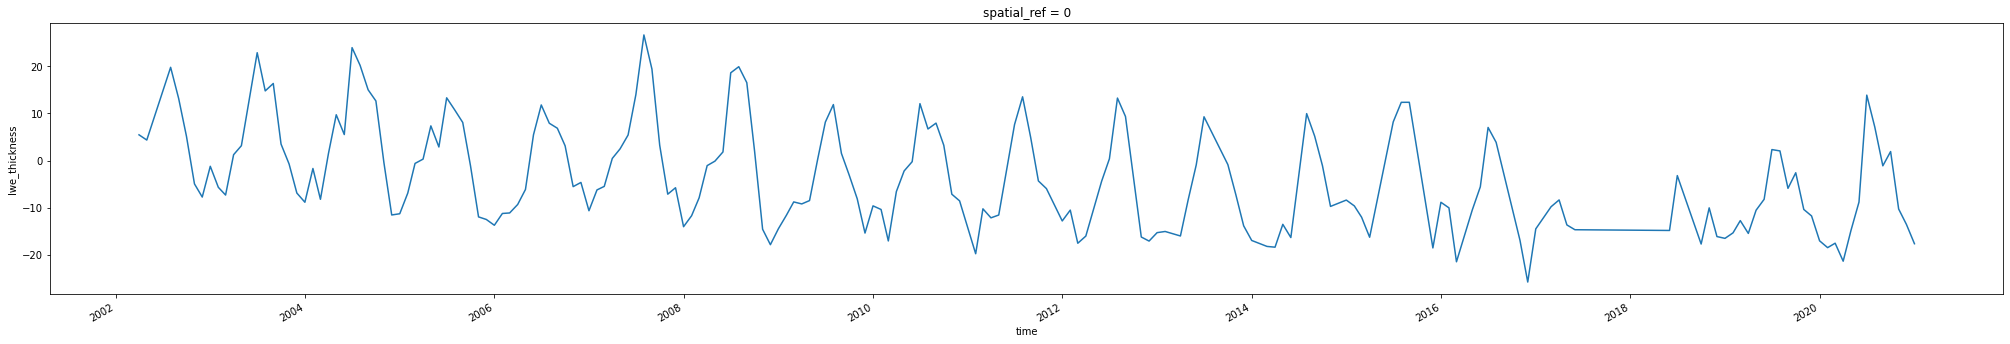

In [61]:
clipped_gw.lwe_thickness.mean(['lat', 'lon']).plot(figsize=(35, 5))

In [62]:
uncertainty_df = clipped_gw.uncertainty.mean(['lat', 'lon']).to_dataframe().reset_index()

In [63]:
uncertainty_df

,time,spatial_ref,uncertainty
0,2002-04-01,0,19.634387
1,2002-05-01,0,8.893863
2,2002-08-01,0,5.513614
3,2002-09-01,0,8.036121
4,2002-10-01,0,4.845762
...,...,...,...
186,2020-09-01,0,3.364021
187,2020-10-01,0,4.182512
188,2020-11-01,0,3.590254
189,2020-12-01,0,6.342410


In [64]:
uncertainty_df.uncertainty.mean()

5.350442564031091